### GraphRepo: Fast Exploration in Software Repository Mining

GraphRepo is a tool used to extract data from Git repositories and index it in Neo4j. 
It recovers the graph structure of repositories and allows fast exploration and experimentation.

The main components of GraphRepo are:

- Drillers - components used to extract data from Git repositories and insert records in Neo4j,
- Miners - components with efault queries and interfaces for retrieving data from Neo4j, and
- Mappers - components used to transform the data retrieved by Miners in specific format, filter or sort data,

as can be seen in the picture below. We will explore all the components in this demo. For more details see the [project's documentation](https://graphrepo.readthedocs.io/en/latest/architecture.html#).

<img src="https://graphrepo.readthedocs.io/en/latest/_images/GraphRepoArch.svg"
 alt="GraphRepo Architecture"
 style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 30%;" />

In [ ]:
! pip install graphrepo

### 1. Indexing a repository

GraphRepo uses a general configuration ``.yml`` file where we have to specify the Neo4j host and authentication properties, and the location of the repository. 

Moreover, we can configure some general flag about that can discard some information.

In this demo we will use a project called [Jax](https://github.com/google/jax). In the repo you will see a ``jax.yml`` file with the configuration. Please stop for a minute and open it. More information about the configuration can be found in the [project's documentation](https://graphrepo.readthedocs.io/en/latest/configuration.html).

In order to index a project in Neo4j, we have to intantiate a ``Driller`` component, which takes as paramater the path of the config file.

In [3]:
from graphrepo.drillers import Driller
import os

# get full file_path
file_path = os.path.join(os.path.dirname(os.path.abspath("GraphRepo Demo.ipynb")), "jax.yml")

# instantiate driller
demo_driller = Driller(file_path)

# ask driller to index the repo
_ = demo_driller.drill_batch()

Driller started at: 	 2020-06-15 09:47:59.085190
Driller finished in: 	 0:08:00.253102
Indexing  182  authors
Indexed authors in: 	 0:00:00.159396
Indexing  3721  commits
Indexed commits in: 	 0:00:02.116757
Indexing  1  branches
Indexed branches in: 	 0:00:00.864950
Indexing  299  files
Indexed files in: 	 0:00:00.043655
Indexing  7963  methods
Indexed methods in: 	 0:00:00.559430
Indexing  4600  parent commits
Indexed commits in: 	 0:00:00.776397
Indexing  3721  author_commits
Indexed author_commits in: 	 0:00:00.589668
Indexings  7963  file_methods
Indexed file_methods in: 	 0:00:00.491862
Indexing  16794  commit_methods
Indexed commit_methods in: 	 0:00:03.834677
Indexing  5845  commit_files
Indexed commit_files in: 	 0:00:02.189705
Indexing took: 	 0:00:11.694858


#### 1.1 Alternatively, index data using caching.

The default Driller (used above) keeps the data extracted from a Git repo in memory, until it indexes it in Neo4j.
Alternatively, GraphRepo provides a CacheDriller, which stores the intermediary data on disk. 

The CacheDriller is slower than the default Driller, but it saves RAM memory, thus providing a trade-off between performance and hardware resource. 

In [ ]:
from graphrepo.drillers import CacheDriller

demo_cache_driller = CacheDriller(file_path)
_ = demo_cache_driller.drill_batch()

### 2. Mining (exploring) a repository

Once repositories are indexed, we can start exploring them. 
The resulting graph schema is shown in the picture below.

The metadata about commit updates, e.g., commit diffs are stored in the 'Update' relationships.

For a complete decription of the attributes, see the [project's documentation](https://graphrepo.readthedocs.io/en/latest/data_structure.html).

<img src="https://graphrepo.readthedocs.io/en/latest/_images/GraphRepoSchema.svg"
 alt="GraphRepo Schema"
 style="display: block;
  margin-left: auto;
  margin-right: auto;
  width: 30%;" />

There are two ways to explore repositories:

- using the Miner components described earlier, or
- using Neo4j queries.

In order to use the Miners, we can instantiate and configure them using the Mine Manager, with the same config file path used for Drillers.

In [23]:
from graphrepo.miners import MineManager

miner = MineManager(file_path)

In [36]:
# Using the mine manager, we can extract data.
# For example, let's get all developer names

devs = miner.dev_miner.get_all()
names = [x['name'] for x in list(devs)]

print(len(names))

182


In [37]:
# Or get the files edited in one commit:
files = miner.commit_miner.get_commit_files("4946be47e9244a0ce0b7d5af3c70476d690516e4dfef26837ddb4b15")

print(len(files))

29


In [50]:
# Or get the file nloc over time, for one file edited in this commit:
file_history =  miner.file_miner.get_change_history(files[8]['hash'])

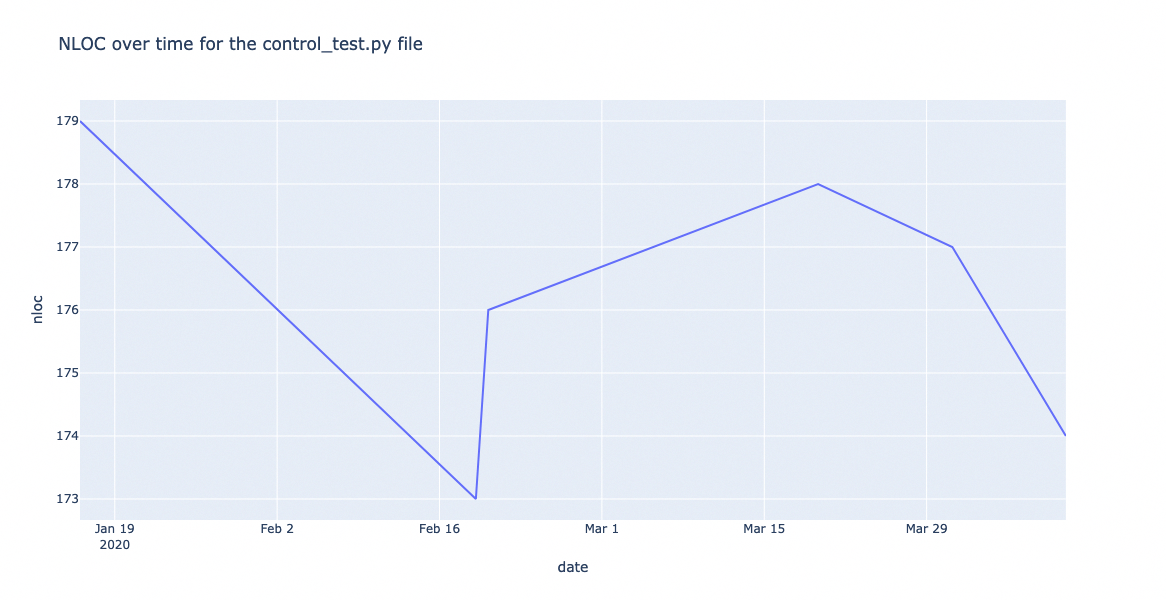

In [54]:
# and plot it using pandas and plotly, 
import pandas as pd
import plotly.express as px

from datetime import datetime

# sort by time
file_history.sort(key=lambda x: x['timestamp'])
n_loc = [x['nloc'] for x in file_history]

# transform the timestamp to date for better formatting
dts = [datetime.fromtimestamp(x['timestamp']) for x in file_history]
# plot
fig = px.line(pd.DataFrame({'date': dts, 'nloc': n_loc}),
                  x='date', y='nloc',
                  title='NLOC over time for the {} file'.format(files[8]['name'])).show()

These are only a subset of the possible queries we can make through the miners.

For a complete description, see the [project's documentation](https://graphrepo.readthedocs.io/en/latest/miners.html).

#### 2.1 Alternatively, mine data using Neo4j queries

Using the Mine Manager (instantiated earlier) we can send Neo4j queries instead of using the Custom Miners.

In [55]:
# E.g., select the nloc for files edited in a commit:
n_locs = miner.graph.run(
    """MATCH (n:Commit {hash: '4946be47e9244a0ce0b7d5af3c70476d690516e4dfef26837ddb4b15'})
    -[r:UpdateFile]->(f:File) 
    return r.nloc order by r.nloc desc"""
)


print(len(list(n_locs)))

29


In [56]:
# Or, get all methods for a file:
methods = miner.graph.run(
    """MATCH (f:File {{hash: "{0}"}})
       - [r:Method] -> (m:Method)
       return m
    """.format(files[8]['hash'])
)

print(len(list(methods)))

4


As you can see, GraphRepo enables real time exploration of software repositories and it is flexible in the way the data can be extracted.

### 3. Mappers

Mappers are custom components that can be used to further process information extracted by Miners, for example by sorting, filtering or converting it to other formats.

Mappers are also designed as an interface to external data processing tools (e.g., Apache Spark or Scikit-learn), in order to provide extensibility and interoperability for GraphRepo.

We also envision Mappers as a way to support experiment reproducibility, i.e., all experiments with GraphRepo can be reproduced by only sharing the configuration files and any custom Mapper.

In [57]:
# For example, let's use the CSV mapper to transform the Miner output to pandas DataFrame
from graphrepo.mappers import CSVMapper
csv_map = CSVMapper()

file_history =  miner.file_miner.get_change_history(files[8]['hash'])
df = csv_map.map(file_history)

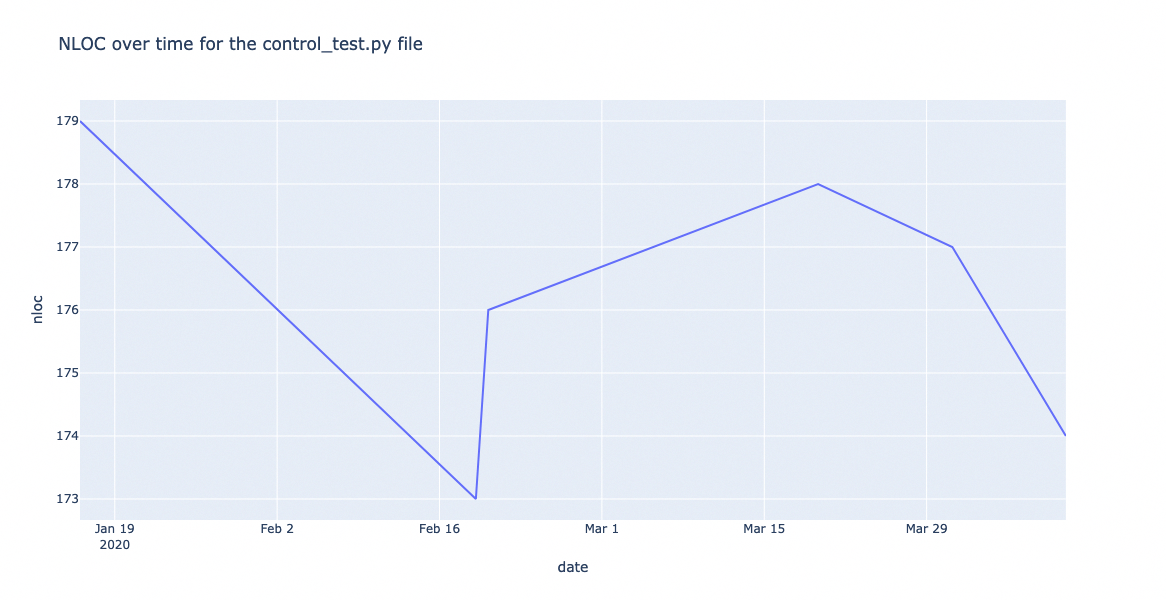

In [58]:
# and now we can plot it with pandas
df = df.sort_values(by='timestamp', axis=0)
df['date'] = df['timestamp'].apply(lambda x:  datetime.fromtimestamp(x))
fig = px.line(df, x='date', y='nloc', title='NLOC over time for the {} file'.format(files[8]['name'])).show()